# CLASSIFICAÇÃO BINÁRIA

Fine-tuning da rede EfficientNet V2 para classificação.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

2023-12-05 19:56:43.363568: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-05 19:56:43.646273: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-05 19:56:43.647757: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-05 19:56:44.903836: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Separar dataset aleatoriamente em Treino e Validação.

Rotina para fazer split automatico de dataset e salvar numa pasta.

Lançar apenas uma vez.

In [3]:
import random
import cv2
import shutil

In [4]:
PATH = r"/home/daniel/Documents/UFSC/Testes/dataset_split"

# Carregar DATASET

In [5]:
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 4
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 25 files belonging to 2 classes.


In [6]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 18 files belonging to 2 classes.


In [7]:
test_dataset = tf.keras.utils.image_dataset_from_directory(r"/home/daniel/Documents/UFSC/scripts/dataset_sintetico/test",
                                                           shuffle=True,
                                                           batch_size=BATCH_SIZE,
                                                           image_size=IMG_SIZE)

Found 240 files belonging to 2 classes.


Dataset TREINAMENTO


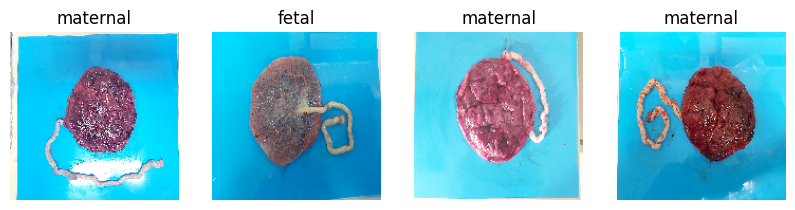

In [8]:
print("Dataset TREINAMENTO")
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(4):
    ax = plt.subplot(1, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")



Dataset VALIDAÇÃO


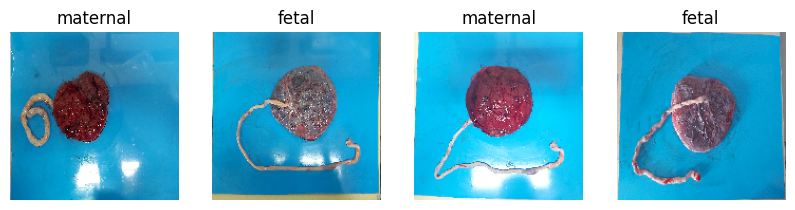

In [9]:
print("Dataset VALIDAÇÃO")
class_names = validation_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in validation_dataset.take(1):
  for i in range(4):
    ax = plt.subplot(1, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Dataset TEST


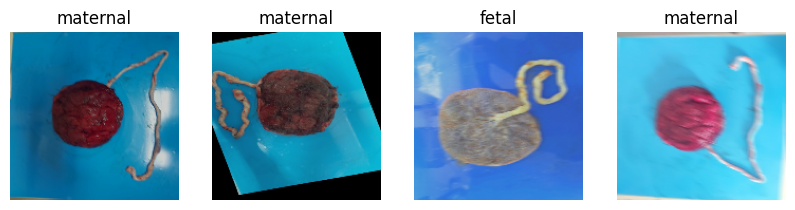

In [10]:
print("Dataset TEST")
class_names = test_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in test_dataset.take(1):
  for i in range(4):
    ax = plt.subplot(1, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [11]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))
print('Number of training batches: %d' % tf.data.experimental.cardinality(train_dataset))

Number of validation batches: 5
Number of test batches: 60
Number of training batches: 7


### Configure the dataset for performance

In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# Data Augmentation

Poucas transformações para aumentar a variabilidade no treinamento.

In [13]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomTranslation(height_factor=0.1,width_factor=0.1),
  
])

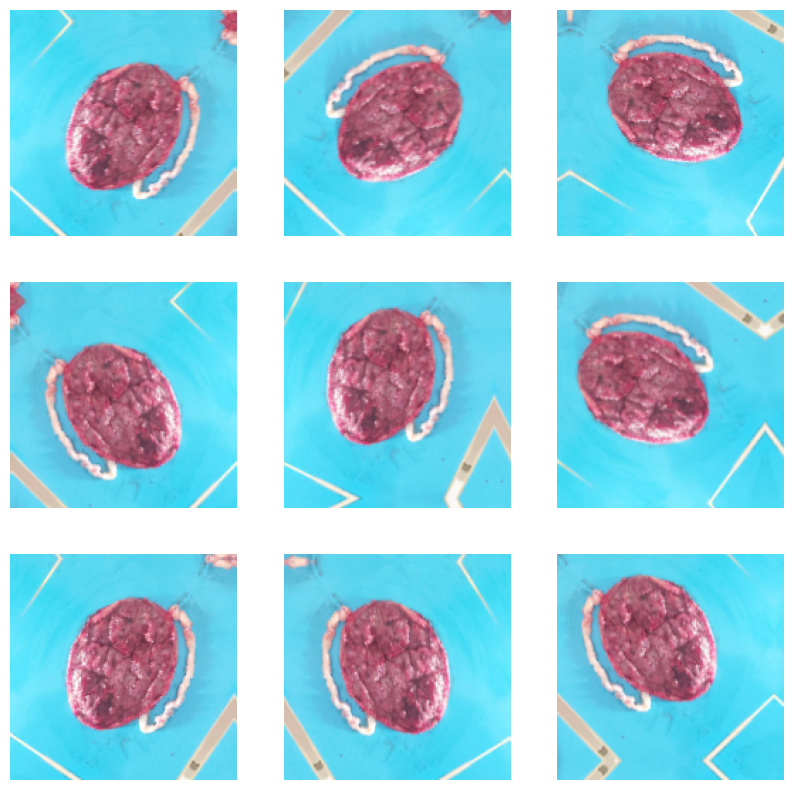

In [14]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    # augmented_image = data_augmentation.augment_image(first_image)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

# Configurar a Rede

In [15]:
preprocess_input = tf.keras.applications.efficientnet_v2.preprocess_input

In [16]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)


base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2L(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [17]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(4, 5, 5, 1280)


In [18]:
base_model.trainable = False

In [19]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "efficientnetv2-l"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 160, 160, 3)          0         ['input_1[0][0]']             
                                                                                                  
 stem_conv (Conv2D)          (None, 80, 80, 32)           864       ['rescaling[0][0]']           
                                                                                                  
 stem_bn (BatchNormalizatio  (None, 80, 80, 32)           128       ['stem_conv[0][0]']           
 n)                                                                                

# Header para Classificação

In [20]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(4, 1280)


In [21]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(4, 1)


In [22]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [23]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 efficientnetv2-l (Function  (None, 5, 5, 1280)        117746848 
 al)                                                             
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 1)                 1281  

In [24]:
len(model.trainable_variables)

2

# Compilar Modelo

In [25]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0, name='accuracy')])

# Pre-treino Modelo

In [26]:
initial_epochs = 40

loss0, accuracy0 = model.evaluate(validation_dataset)

5/5 [==============================] - 10s 570ms/step - loss: 0.7305 - accuracy: 0.5000


In [27]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.73
initial accuracy: 0.50


In [28]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/40


7/7 [==============================] - 33s 1s/step - loss: 0.7741 - accuracy: 0.2800 - val_loss: 0.7219 - val_accuracy: 0.5556
Epoch 2/40
7/7 [==============================] - 8s 1s/step - loss: 0.7546 - accuracy: 0.2800 - val_loss: 0.7141 - val_accuracy: 0.5556
Epoch 3/40
7/7 [==============================] - 8s 1s/step - loss: 0.7780 - accuracy: 0.3600 - val_loss: 0.7062 - val_accuracy: 0.5556
Epoch 4/40
7/7 [==============================] - 9s 1s/step - loss: 0.7756 - accuracy: 0.4400 - val_loss: 0.6984 - val_accuracy: 0.5556
Epoch 5/40
7/7 [==============================] - 9s 1s/step - loss: 0.7381 - accuracy: 0.3600 - val_loss: 0.6914 - val_accuracy: 0.5556
Epoch 6/40
7/7 [==============================] - 8s 1s/step - loss: 0.6860 - accuracy: 0.5600 - val_loss: 0.6851 - val_accuracy: 0.5556
Epoch 7/40
7/7 [==============================] - 8s 1s/step - loss: 0.7053 - accuracy: 0.5200 - val_loss: 0.6786 - val_accuracy: 0.5556
Epoch 8/40
7/7 [==============================] - 8

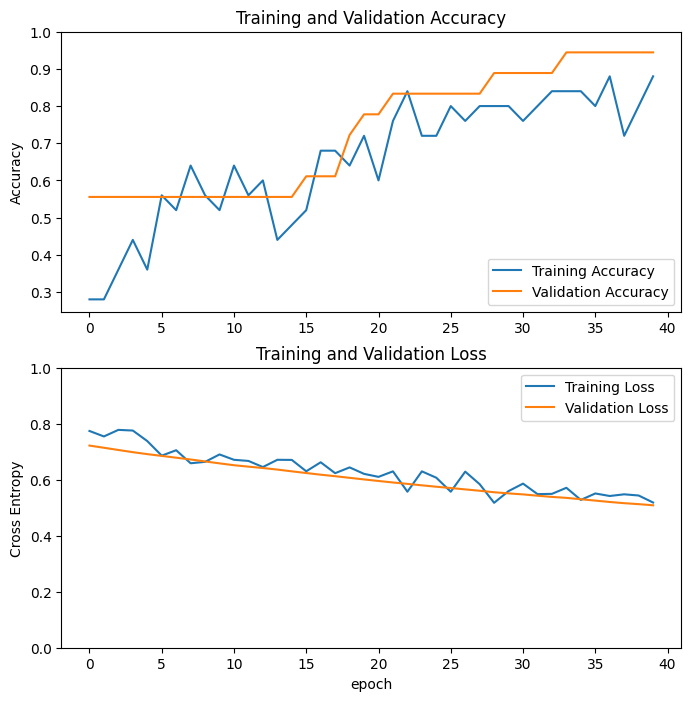

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine tuning


### Un-freeze the top layers of the model


In [30]:
base_model.trainable = True

In [31]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  1028


In [32]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0, name='accuracy')])

In [33]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 efficientnetv2-l (Function  (None, 5, 5, 1280)        117746848 
 al)                                                             
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 1)                 1281  

In [34]:
len(model.trainable_variables)

813

In [35]:
fine_tune_epochs = 40
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 40/80
7/7 [==============================] - 88s 4s/step - loss: 0.4348 - accuracy: 0.8800 - val_loss: 0.4854 - val_accuracy: 0.8333
Epoch 41/80
7/7 [==============================] - 19s 3s/step - loss: 0.2185 - accuracy: 0.9600 - val_loss: 0.2372 - val_accuracy: 1.0000
Epoch 42/80
7/7 [==============================] - 19s 3s/step - loss: 0.2152 - accuracy: 0.9600 - val_loss: 0.2469 - val_accuracy: 0.9444
Epoch 43/80
7/7 [==============================] - 19s 3s/step - loss: 0.1350 - accuracy: 1.0000 - val_loss: 0.1018 - val_accuracy: 1.0000
Epoch 44/80
7/7 [==============================] - 19s 3s/step - loss: 0.1253 - accuracy: 0.9600 - val_loss: 0.0734 - val_accuracy: 1.0000
Epoch 45/80
7/7 [==============================] - 19s 3s/step - loss: 0.0375 - accuracy: 1.0000 - val_loss: 0.0818 - val_accuracy: 1.0000
Epoch 46/80
7/7 [==============================] - 19s 3s/step - loss: 0.0270 - accuracy: 1.0000 - val_loss: 0.0975 - val_accuracy: 1.0000
Epoch 47/80
7/7 [==========

In [36]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

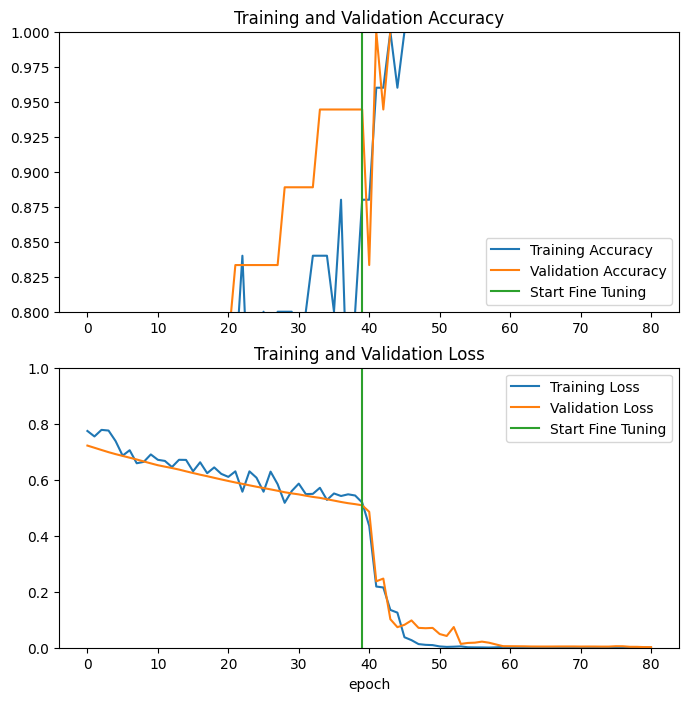

In [37]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Evaluation and prediction

In [38]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

60/60 [==============================] - 44s 729ms/step - loss: 0.1491 - accuracy: 0.9167
Test accuracy : 0.9166666865348816


In [39]:
for image_batch, label_batch in test_dataset.as_numpy_iterator():
    predictions = model.predict_on_batch(image_batch).flatten()
    predictions = tf.nn.sigmoid(predictions)
    predictions = tf.where(predictions < 0.5, 0, 1)

    print('Predictions vs Label:')
    print( predictions.numpy())
    print( label_batch)


Predictions vs Label:
[0 1 1 1]
[0 1 1 1]
Predictions vs Label:
[0 0 1 0]
[0 1 1 0]
Predictions vs Label:
[0 0 1 0]
[0 1 1 0]
Predictions vs Label:
[1 0 0 0]
[1 0 1 0]
Predictions vs Label:
[0 1 1 0]
[0 1 1 0]
Predictions vs Label:
[0 0 0 1]
[0 1 0 1]
Predictions vs Label:
[0 0 0 0]
[0 1 1 0]
Predictions vs Label:
[1 0 1 1]
[1 0 1 1]
Predictions vs Label:
[0 0 1 1]
[0 1 1 1]
Predictions vs Label:
[0 1 0 0]
[0 1 0 0]
Predictions vs Label:
[0 0 0 0]
[0 0 0 0]
Predictions vs Label:
[0 1 0 0]
[0 1 0 0]
Predictions vs Label:
[1 0 0 0]
[1 0 0 1]
Predictions vs Label:
[1 0 1 1]
[1 1 1 1]
Predictions vs Label:
[1 0 0 1]
[1 0 0 1]
Predictions vs Label:
[0 1 0 0]
[0 1 1 0]
Predictions vs Label:
[1 1 0 0]
[1 1 1 0]
Predictions vs Label:
[0 0 1 0]
[0 0 1 0]
Predictions vs Label:
[0 0 1 0]
[0 0 1 0]
Predictions vs Label:
[1 0 0 0]
[1 0 0 0]
Predictions vs Label:
[0 1 1 0]
[1 1 1 0]
Predictions vs Label:
[0 1 0 0]
[0 1 0 1]
Predictions vs Label:
[1 0 1 0]
[1 0 1 0]
Predictions vs Label:
[0 0 1 0]
[0

Predictions:
 [0 1 0 0]
Labels:
 [0 1 1 0]


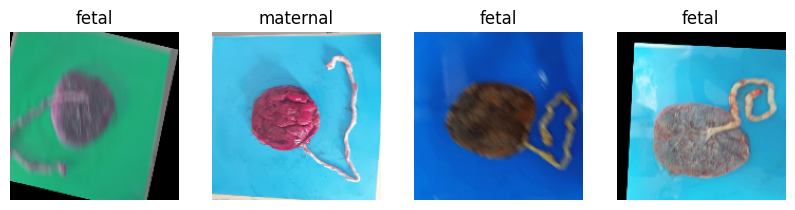

In [40]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(4):
  ax = plt.subplot(1, 4, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")